In [1]:
import numpy as np
import cv2
from PIL import Image
import os
import skimage as ski
import matplotlib.pyplot as plt
import pywt
from skimage import io, restoration, util, metrics, data, img_as_float
from natsort import natsorted, ns
from inference import get_model
from inference_sdk import InferenceHTTPClient
from inference.models.utils import get_roboflow_model
from ultralytics import YOLO, settings
from functools import partial
import scipy

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Load training images from dataset.

In [2]:
def load_images(folder):
    images = []
    try:
        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            try:
                img = Image.open(img_path)
                images.append(img)
            except IOError as e:
                print(f"Could not open image {img_path}: {e}")
    except PermissionError as e:
        print(f"Permission denied: {e}")
    return images

image_path = "C:/Users/needh/OneDrive/Documents/Uni/2024/Sem_2_2024/ICT342/SEAING/Training Images/Underwater Marine Species.v6-marinedataset_v5.yolov8/train/images"

images = load_images(image_path)

Calibrate Scikit wavelet denoiser

In [ ]:
from skimage.restoration import denoise_wavelet, calibrate_denoiser
from skimage.data import chelsea, hubble_deep_field
from skimage.util import random_noise
import numpy as np
import matplotlib.pyplot as plt

denoise_wavelet = partial(denoise_wavelet, rescale_sigma=True)

image = img_as_float(chelsea())
sigma = 0.2
noisy = random_noise(image, var=sigma**2)

parameter_ranges = {
    'sigma': np.arange(0.1, 0.3, 0.02),
    'wavelet': ['db1', 'db2'],
    'convert2ycbcr': [True, False],
    'channel_axis': [-1],
}

default_output = denoise_wavelet(noisy, channel_axis=-1, rescale_sigma=True)

calibrated_denoiser = calibrate_denoiser(
    noisy, denoise_wavelet, denoise_parameters=parameter_ranges
)

calibrated_output = calibrated_denoiser(noisy)

fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))

for ax, img, title in zip(
    axes,
    [noisy, default_output, calibrated_output],
    ['Noisy Image', 'Denoised (Default)', 'Denoised (Calibrated)'],
):
    ax.imshow(img)
    ax.set_title(title)
    ax.set_yticks([])
    ax.set_xticks([])


Adjust r,g,b channels and apply wavelet denoising.

In [ ]:
# Enhancements only applied on one image for testing purposes atm and doesn't use the code above.
image = io.imread('C:/Users/needh/OneDrive/Documents/Uni/2024/Sem_2_2024/ICT342/SEAING/Training Images/Underwater Marine Species.v6-marinedataset_v5.yolov8/train/images/0HM9KWRRG6FN_jpg.rf.58681507bb0c920c258c1699ec9a6175.jpg')
image = img_as_float(image)

#Testing splitting image into r, g, b first before denoising.
r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]

# r = b * 1.0 # Adjust the factor as needed
# g = g * 0.5 # Adjust the factor as needed
# b = b * 0.5 # Adjust the factor as needed

enhanced_image = np.stack((r, g, b), axis=-1)

# Denoise image
denoised_image = restoration.denoise_wavelet(enhanced_image)

# Display the original and enhanced images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(denoised_image) #enhanced image
ax[1].set_title('Enhanced Image')
ax[1].axis('off')

plt.show()

Adjust r,g,b channels and apply some other denoising.

In [ ]:
# Put other denoising method here to compare it to wavelet denoising.




Apply Richardson-Lucy deconvolution

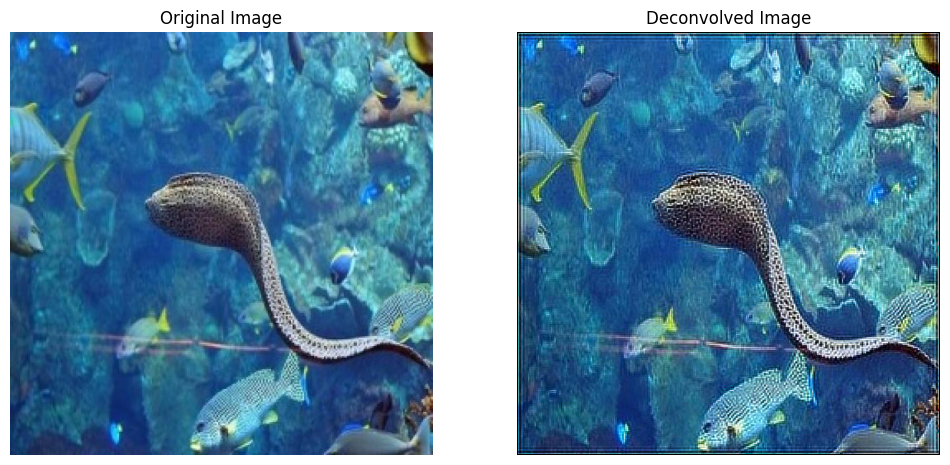

In [14]:
import numpy as np
from scipy.signal import convolve2d
from skimage.restoration import richardson_lucy

image = io.imread('C:/Users/needh/OneDrive/Documents/Uni/2024/Sem_2_2024/ICT342/SEAING/Training Images/Underwater Marine Species.v6-marinedataset_v5.yolov8/train/images/0HM9KWRRG6FN_jpg.rf.58681507bb0c920c258c1699ec9a6175.jpg')
image = img_as_float(image)

# Apply Richardson-Lucy deconvolution
psf = np.ones((5, 5, 1)) / 25  # Point Spread Function (PSF)
deconvolved_image = richardson_lucy(image, psf, num_iter=30)

# Display the original and deconvolved images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(deconvolved_image)
ax[1].set_title('Deconvolved Image')
ax[1].axis('off')

plt.show()

Load labels from dataset.

In [ ]:
def load_labels(folder):
    labels = {}
    try:
        for filename in os.listdir(folder):
            if filename.endswith(".txt"):
                label_path = os.path.join(folder, filename)
                with open(label_path, 'r') as file:
                    label_data = file.readlines()
                    labels[filename] = [line.strip() for line in label_data]
    except PermissionError as e:
        print(f"Permission denied: {e}")
    return labels

label_path = "C:/Users/needh/OneDrive/Documents/Uni/2024/Sem_2_2024/ICT342/SEAING/Training Images/Underwater Marine Species.v6-marinedataset_v5.yolov8/train/labels"
labels = load_labels(label_path)
print(labels)

Setup/Check Ultralytics and set correct directory path.

In [ ]:
print(settings)

value = settings["runs_dir"]
settings.update({"datasets_dir": "C:/Users/needh/OneDrive/Documents/Uni/2024/Sem_2_2024/ICT342/SEAING/Training Images/Underwater Marine Species.v6-marinedataset_v5.yolov8"})

Import Roboflow pre-trained dataset "Underwater Marine Species Computer Vision Project"

In [ ]:
# Add your own image path to any arbitrary image. It currently only loads one image so we need to figure out how to load all images.
image_path = "C:/Users/needh/OneDrive/Documents/Uni/2024/Sem_2_2024/ICT342/SEAING/Training Images/Underwater Marine Species.v6-marinedataset_v5.yolov8/train/images/288856187_d1fb57a113_b_jpg.rf.1a861f6bf38998d756e6f76a84b73340.jpg"

# Roboflow model
model_name = "underwater-marine-species"
model_version = "6"

# Get Roboflow face model (this will fetch the model from Roboflow)
model = get_roboflow_model(
    model_id="{}/{}".format(model_name, model_version),

    #Replace ROBOFLOW_API_KEY with your Roboflow API Key
    api_key="J7ljP04frhJRcBuovOmD"
)

In [6]:
frame = cv2.imread(image_path)

results = model.infer(image=frame,
                        confidence=0.5,
                        iou_threshold=0.5)

In [ ]:
if results[0].predictions:
    prediction = results[0].predictions[0]
    print(prediction)
    
    x_center = int(prediction.x)
    y_center = int(prediction.y)
    width = int(prediction.width)
    height = int(prediction.height)

    # Calculate top-left and bottom-right corners from center, width, and height
    x0 = x_center - width // 2
    y0 = y_center - height // 2
    x1 = x_center + width // 2
    y1 = y_center + height // 2
    
    # Currently only takes one input text as a label
    cv2.rectangle(frame, (x0, y0), (x1, y1), (255,255,0), 10)
    cv2.putText(frame, "fish", (x0, y0 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)

Display chosen image.

In [8]:
# Show the image from image path. When we get multiple/all images to be loaded we don't want them all to be rendered simultaneously, so this will need to be modified.
cv2.imshow('Image Frame', frame)
cv2.waitKey(0) # waits until a key is pressed
cv2.destroyAllWindows() # destroys the window showing image